# Clustering Tweets about ChatGPT

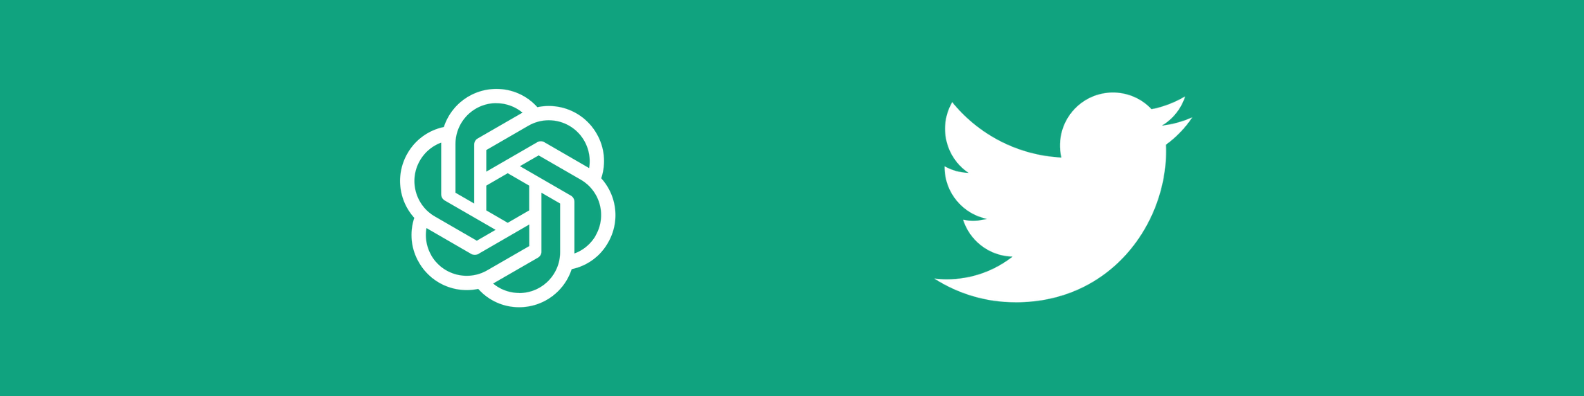

## Problem Statement

El objetivo de este proyecto es el desarrollo de un análisis clúster empleando los *embeddings* generados por el modelo de procesamiento de lenguaje *BERT (Bidirectional Encoder Representations from Transformers)* a partir de los tweets extraídos que contienen el #ChatGPT.

## Import Packages

In [37]:
import tweepy
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer
from collections import Counter

import warnings
warnings.filterwarnings('ignore')

## Data Collection

In [58]:
api_key = 'd...'
api_key_secret = 'Q...'

auth = tweepy.OAuth2AppHandler(api_key, api_key_secret)
api = tweepy.API(auth, wait_on_rate_limit=True)

In [59]:
hashtag = '#ChatGPT'
limit = 100

In [60]:
# Functions

def text_filter(s_data: str) -> str:
    """ Remove extra characters from text """
    return s_data.replace("&amp;", "and").replace(";", " ").replace(",", " ") \
                 .replace('"', " ").replace("\n", " ").replace("  ", " ")

def get_hashtags(tweet) -> str:
    """ Parse retweeted data """
    hash_tags = ""
    if 'hashtags' in tweet.entities:
        hash_tags = ','.join(map(lambda x: x["text"], tweet.entities['hashtags']))
    return hash_tags

def get_csv_header() -> str:
    """ CSV header """
    return "id;created_at;user_name;user_location;user_followers_count;user_friends_count;retweets_count;favorites_count;retweet_orig_id;retweet_orig_user;hash_tags;full_text"

def tweet_to_csv(tweet):
    """ Convert a tweet data to the CSV string """
    if not hasattr(tweet, 'retweeted_status'):
        full_text = text_filter(tweet.full_text)
        hasgtags = get_hashtags(tweet)
        retweet_orig_id = ""
        retweet_orig_user = ""
        favs, retweets = tweet.favorite_count, tweet.retweet_count
    else:
        retweet = tweet.retweeted_status
        retweet_orig_id = retweet.id
        retweet_orig_user = retweet.user.screen_name
        full_text = text_filter(retweet.full_text)
        hasgtags = get_hashtags(retweet)
        favs, retweets = retweet.favorite_count, retweet.retweet_count
    s_out = f"{tweet.id};{tweet.created_at};{tweet.user.screen_name};{tweet.user.location};{tweet.user.followers_count};{tweet.user.friends_count};{retweets};{favs};{retweet_orig_id};{retweet_orig_user};{hasgtags};{full_text}"
    return s_out

pages = tweepy.Cursor(api.search_tweets, q=hashtag, tweet_mode='extended',
                      result_type="recent",
                      count=100,
                      lang="en").pages(limit)

with open("tweets.csv", "a", encoding="utf-8") as f_log:
    f_log.write(get_csv_header() + "\n")
    for ind, page in enumerate(pages):
        for tweet in page:
            # Get data per tweet
            str_line = tweet_to_csv(tweet)
            # Save to CSV
            f_log.write(str_line + "\n")

## Data Reading

In [2]:
pd.options.display.max_columns=None

tweets_df = pd.read_csv('tweets.csv', sep=';', engine='python', header=None)
tweets_df = tweets_df.set_axis(tweets_df.iloc[0].to_list(), axis='columns')
tweets_df = tweets_df.iloc[8:-1]
tweets_df = tweets_df.drop_duplicates(subset='full_text')
tweets_df = tweets_df.dropna(subset='full_text').reset_index(drop=True)
tweets_df.shape

(5532, 12)

In [3]:
tweets_df.head()

,id,created_at,user_name,user_location,user_followers_count,user_friends_count,retweets_count,favorites_count,retweet_orig_id,retweet_orig_user,hash_tags,full_text
0,1658427597842202625,2023-05-16 11:02:06+00:00,DigWatchWorld,Global,13444,341,0,0,NaN,NaN,"Italy,money,AI,digwatch,dWobservatory,Artifici...",#Italy is investing #money to protect workers ...
1,1658427582793089026,2023-05-16 11:02:02+00:00,JacobusSystems,"Brighton & Hove, UK",2488,629,1,0,1658427122732486656,hackernoon,"chatgpt,ai",How I connected an external app to ChatGPT - h...
2,1658427523909263360,2023-05-16 11:01:48+00:00,danielbxxxxx,NaN,15,85,0,0,NaN,NaN,"AI,ETH,ChatGPT,CryptoAI,Krypto",@Crypto__Diva With $CAI that will be me in the...
3,1658427474999406595,2023-05-16 11:01:36+00:00,saadnajeebsaad,NaN,92,569,0,0,NaN,NaN,"WeatherUpdate,Karachi,Khi,TempUpdate,Sunrise,S...",#WeatherUpdate #Karachi #Khi #TempUpdate #Sunr...
4,1658427466900205570,2023-05-16 11:01:34+00:00,TheSuperASK,"Gurgaon, India",4389,1758,0,0,NaN,NaN,ChatGPT,What ChatGPT or AI will not have is set of Tra...


## Text Cleaning and Transformation

In [4]:
import re
import pandas as pd
from nltk.tokenize import TweetTokenizer

from nltk.corpus import stopwords
stop = set(stopwords.words("english"))

import spacy
nlp = spacy.load('en_core_web_sm')

def remove_stopwords(text) -> str:
    """ Remove stopwords from text """
    filtered_words = [word for word in text.split() if word.lower() not in stop]
    return " ".join(filtered_words)

def expand_hashtag(tag: str):
    """ Convert #HashTag to separated words.
    '#ActOnClimate' => 'Act On Climate'
    '#climate' => 'climate' """
    res = re.findall('[A-Z]+[^A-Z]*', tag)
    return ' '.join(res) if len(res) > 0 else tag[1:]

def expand_hashtags(s: str):
    """ Convert string with hashtags.
    '#ActOnClimate now' => 'Act On Climate now' """
    res = re.findall(r'#\w+', s) 
    s_out = s
    for tag in re.findall(r'#\w+', s):
        s_out = s_out.replace(tag, expand_hashtag(tag))
    return s_out

def remove_last_hashtags(s: str):
    """ Remove all hashtags at the end of the text except #url """
    # "Change in #mind AP #News #Environment" => "Change in #mind AP"
    tokens = TweetTokenizer().tokenize(s)
    # If the URL was added, keep it
    url = "#url" if "#url" in tokens else None
    # Remove hashtags
    while len(tokens) > 0 and tokens[-1].startswith("#"):
        tokens = tokens[:-1]
    # Restore 'url' if it was added
    if url is not None:
        tokens.append(url)
    return ' '.join(tokens) 

def lemmatize(sentence: str) -> str:
    """ Convert all words in sentence to lemmatized form """
    return " ".join([token.lemma_ for token in nlp(sentence)])

def text_clean(s_text: str) -> str:
    """ Text clean """
    try:
        output = re.sub(r"https?://\S+", "#url", s_text)  # Replace hyperlinks with '#url'
        output = re.sub(r'@\w+', '', output)  # Remove mentioned user names @... 
        output = remove_last_hashtags(output)  # Remove hashtags from the end of a string
        output = expand_hashtags(output)  # Expand hashtags to words
        output = re.sub("[^a-zA-Z]+", " ", output) # Filter
        output = re.sub(r"\s+", " ", output)  # Remove multiple spaces
        output = remove_stopwords(output)  # Remove stopwords
        return output.lower().strip()
    except:
        return ""

def text_len(s_text: str) -> int:
    """ Length of the text """
    return len(s_text)

In [5]:
tweets_df['text_clean'] = tweets_df['full_text'].map(text_clean)
tweets_df['text_len'] = tweets_df['text_clean'].map(text_len)

tweets_df.head()

,id,created_at,user_name,user_location,user_followers_count,user_friends_count,retweets_count,favorites_count,retweet_orig_id,retweet_orig_user,hash_tags,full_text,text_clean,text_len
0,1658427597842202625,2023-05-16 11:02:06+00:00,DigWatchWorld,Global,13444,341,0,0,NaN,NaN,"Italy,money,AI,digwatch,dWobservatory,Artifici...",#Italy is investing #money to protect workers ...,italy investing money protect workers threat a...,64
1,1658427582793089026,2023-05-16 11:02:02+00:00,JacobusSystems,"Brighton & Hove, UK",2488,629,1,0,1658427122732486656,hackernoon,"chatgpt,ai",How I connected an external app to ChatGPT - h...,connected external app chatgpt url,34
2,1658427523909263360,2023-05-16 11:01:48+00:00,danielbxxxxx,NaN,15,85,0,0,NaN,NaN,"AI,ETH,ChatGPT,CryptoAI,Krypto",@Crypto__Diva With $CAI that will be me in the...,cai future proud part mass adoption artificial...,63
3,1658427474999406595,2023-05-16 11:01:36+00:00,saadnajeebsaad,NaN,92,569,0,0,NaN,NaN,"WeatherUpdate,Karachi,Khi,TempUpdate,Sunrise,S...",#WeatherUpdate #Karachi #Khi #TempUpdate #Sunr...,weather update karachi khi temp update sunrise...,172
4,1658427466900205570,2023-05-16 11:01:34+00:00,TheSuperASK,"Gurgaon, India",4389,1758,0,0,NaN,NaN,ChatGPT,What ChatGPT or AI will not have is set of Tra...,chatgpt ai set traumas one changed mindset pai...,77


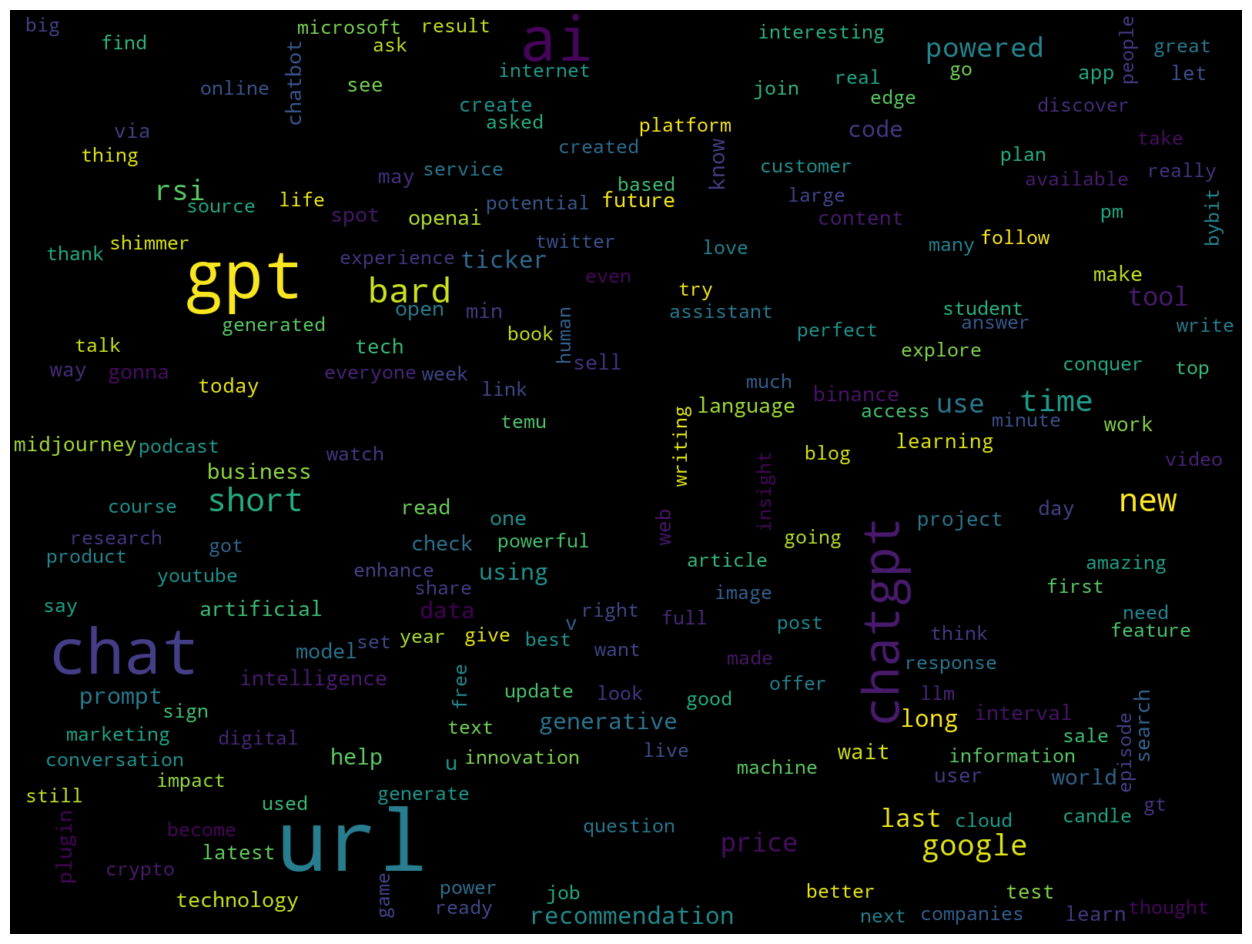

In [6]:
from wordcloud import WordCloud

def draw_cloud(column: pd.Series, stopwords=None):
    all_words = ' '.join([text for text in column]) 
    
    wordcloud = WordCloud(width=1600, height=1200, random_state=21, max_font_size=110, collocations=False, stopwords=stopwords).generate(all_words) 
    plt.figure(figsize=(16, 12)) 
    plt.imshow(wordcloud, interpolation="bilinear") 
    plt.axis('off')
    plt.show()    
    
draw_cloud(tweets_df['text_clean'])

La nube de palabras muestra que la gente publica enlaces de forma asidua, al ser "URL" la palabra más grande. Destacan palabras como "innovation", "amazing" o "powerful".

## Vectorization

Al ser los *embeddings* generados por *BERT* sensibles al contexto de las palabras, no se empleará la columna "text_clean" como se hizo anteriormente en la representación de la nube de palabras. En su lugar, solo serán convertidas las URL de los tweets y los hashtags en texto.

In [13]:
from sentence_transformers import SentenceTransformer

def partial_clean(s_text: str) -> str:
    """ Convert tweet to a plain text sentence """
    output = re.sub(r"https?://\S+", "#url", s_text)  # Replace hyperlinks with '#url'
    output = re.sub(r'@\w+', '', output)  # Remove mentioned user names @... 
    output = remove_last_hashtags(output)  # Remove hashtags from the end of a string
    output = expand_hashtags(output)  # Expand hashtags to words
    output = re.sub(r"\s+", " ", output)  # Remove multiple spaces
    return output

docs = tweets_df['full_text'].map(partial_clean).values
model = SentenceTransformer('all-MiniLM-L6-v2')
vectorized_docs = model.encode(np.asarray(docs))
print("Shape:", vectorized_docs.shape)

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/350 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/13.2k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/349 [00:00<?, ?B/s]

Shape: (5532, 384)


Como salida, se obtiene un vector de 384 dimensiones para cada uno de los 5532 tweets.

In [23]:
Sentence_BERT = pd.DataFrame(vectorized_docs)
Sentence_BERT.columns = ['Element_' + str(i+1) for i in range(0, Sentence_BERT.shape[1])]
dataset = pd.concat([tweets_df[['id', 'user_name', 'full_text', 'text_clean']], Sentence_BERT], axis=1, sort=False)
dataset.head()

,id,user_name,full_text,text_clean,Element_1,Element_2,Element_3,Element_4,Element_5,Element_6,Element_7,Element_8,Element_9,Element_10,Element_11,Element_12,Element_13,Element_14,Element_15,Element_16,Element_17,Element_18,Element_19,Element_20,Element_21,Element_22,Element_23,Element_24,Element_25,Element_26,Element_27,Element_28,Element_29,Element_30,Element_31,Element_32,Element_33,Element_34,Element_35,Element_36,Element_37,Element_38,Element_39,Element_40,Element_41,Element_42,Element_43,Element_44,Element_45,Element_46,Element_47,Element_48,Element_49,Element_50,Element_51,Element_52,Element_53,Element_54,Element_55,Element_56,Element_57,Element_58,Element_59,Element_60,Element_61,Element_62,Element_63,Element_64,Element_65,Element_66,Element_67,Element_68,Element_69,Element_70,Element_71,Element_72,Element_73,Element_74,Element_75,Element_76,Element_77,Element_78,Element_79,Element_80,Element_81,Element_82,Element_83,Element_84,Element_85,Element_86,Element_87,Element_88,Element_89,Element_90,Element_91,Element_92,Element_93,Element_94,Element_95,Element_96,Element_97,Element_98,Element_99,Element_100,Element_101,Element_102,Element_103,Element_104,Element_105,Element_106,Element_107,Element_108,Element_109,Element_110,Element_111,Element_112,Element_113,Element_114,Element_115,Element_116,Element_117,Element_118,Element_119,Element_120,Element_121,Element_122,Element_123,Element_124,Element_125,Element_126,Element_127,Element_128,Element_129,Element_130,Element_131,Element_132,Element_133,Element_134,Element_135,Element_136,Element_137,Element_138,Element_139,Element_140,Element_141,Element_142,Element_143,Element_144,Element_145,Element_146,Element_147,Element_148,Element_149,Element_150,Element_151,Element_152,Element_153,Element_154,Element_155,Element_156,Element_157,Element_158,Element_159,Element_160,Element_161,Element_162,Element_163,Element_164,Element_165,Element_166,Element_167,Element_168,Element_169,Element_170,Element_171,Element_172,Element_173,Element_174,Element_175,Element_176,Element_177,Element_178,Element_179,Element_180,Element_181,Element_182,Element_183,Element_184,Element_185,Element_186,Element_187,Element_188,Element_189,Element_190,Element_191,Element_192,Element_193,Element_194,Element_195,Element_196,Element_197,Element_198,Element_199,Element_200,Element_201,Element_202,Element_203,Element_204,Element_205,Element_206,Element_207,Element_208,Element_209,Element_210,Element_211,Element_212,Element_213,Element_214,Element_215,Element_216,Element_217,Element_218,Element_219,Element_220,Element_221,Element_222,Element_223,Element_224,Element_225,Element_226,Element_227,Element_228,Element_229,Element_230,Element_231,Element_232,Element_233,Element_234,Element_235,Element_236,Element_237,Element_238,Element_239,Element_240,Element_241,Element_242,Element_243,Element_244,Element_245,Element_246,Element_247,Element_248,Element_249,Element_250,Element_251,Element_252,Element_253,Element_254,Element_255,Element_256,Element_257,Element_258,Element_259,Element_260,Element_261,Element_262,Element_263,Element_264,Element_265,Element_266,Element_267,Element_268,Element_269,Element_270,Element_271,Element_272,Element_273,Element_274,Element_275,Element_276,Element_277,Element_278,Element_279,Element_280,Element_281,Element_282,Element_283,Element_284,Element_285,Element_286,Element_287,Element_288,Element_289,Element_290,Element_291,Element_292,Element_293,Element_294,Element_295,Element_296,Element_297,Element_298,Element_299,Element_300,Element_301,Element_302,Element_303,Element_304,Element_305,Element_306,Element_307,Element_308,Element_309,Element_310,Element_311,Element_312,Element_313,Element_314,Element_315,Element_316,Element_317,Element_318,Element_319,Element_320,Element_321,Element_322,Element_323,Element_324,Element_325,Element_326,Element_327,Element_328,Element_329,Element_330,Element_331,Element_332,Element_333,Element_334,Element_335,Element_336,Element_337,Element_338,Element_339,Eleme

## Clustering and Visualization

Antes de utilizar el método *K-Means* es determinante seleccionar la "K", número óptimo de conglomerados. El gráfica de sedimentación da una idea a la hora de seleccionar el valor de *K* óptimo. Sin embargo, en la práctica, rara vez funciona como se espera, especialmente para conjuntos de datos mal estructurados como los tweets vectorizados, pero el gráfico puede dar algunas ideas.

Processing: 2
Processing: 4
Processing: 6
Processing: 8
Processing: 10
Processing: 12
Processing: 14
Processing: 16
Processing: 18
Processing: 20
Processing: 22
Processing: 24
Processing: 26
Processing: 28
Processing: 30
Processing: 32
Processing: 34
Processing: 36
Processing: 38
Processing: 40
Processing: 42
Processing: 44
Processing: 46
Processing: 48


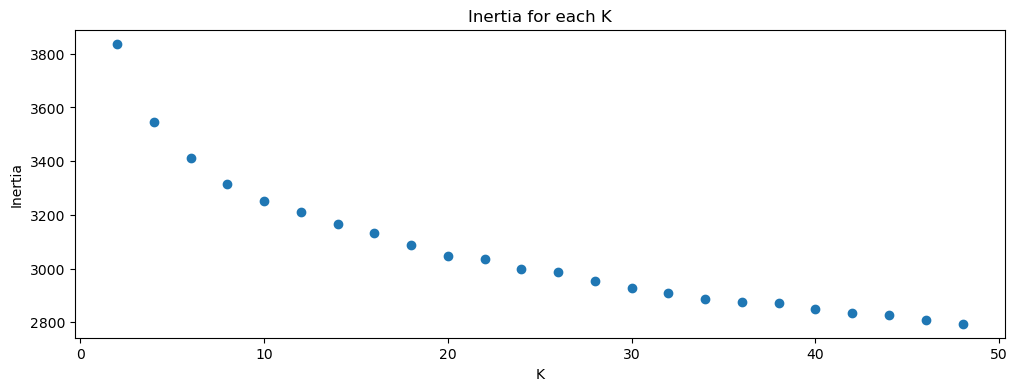

In [42]:
from sklearn.cluster import KMeans

def graw_elbow_graph(x: np.array, k1: int, k2: int, k3: int):
    k_values, inertia_values = [], []
    for k in range(k1, k2, k3):
        print("Processing:", k)
        km = KMeans(n_clusters=k).fit(x)
        k_values.append(k)
        inertia_values.append(km.inertia_)

    plt.figure(figsize=(12,4))
    plt.plot(k_values, inertia_values, 'o')
    plt.title('Inertia for each K')
    plt.xlabel('K')
    plt.ylabel('Inertia')

graw_elbow_graph(vectorized_docs, 2, 50, 2)

In [105]:
from nltk.tokenize import word_tokenize
from sklearn.metrics import silhouette_score

def make_clustered_dataframe(x: np.array, k: int) -> pd.DataFrame:
    """ Create a new dataframe with original docs and assigned clusters """
    ids = dataset["id"].values
    user_names = dataset["user_name"].values
    docs = dataset["text_clean"].values
    tokenized_docs = dataset["text_clean"].map(text_to_tokens).values
    
    km = KMeans(n_clusters=k).fit(x)
    s_score = silhouette_score(x, km.labels_)
    print(f"K={k}: Silhouette coefficient {s_score:0.2f}, inertia:{km.inertia_}")
    
    # Create new DataFrame
    data_len = x.shape[0]
    df_clusters = pd.DataFrame({
        "id": ids[:data_len],
        "user": user_names[:data_len],
        "text": docs[:data_len],
        "tokens": tokenized_docs[:data_len],
        "cluster": km.labels_,
    })
    return df_clusters

def text_to_tokens(text: str) -> list[str]:
    """ Generate tokens from the sentence """
    # "this is text" => ['this', 'is' 'text']
    tokens = word_tokenize(text)  # Get tokens from text
    tokens = [t for t in tokens if len(t) > 1]  # Remove short tokens
    return tokens

# Make clustered dataframe
k = 9
df_clusters = make_clustered_dataframe(vectorized_docs, k)
with pd.option_context('display.max_colwidth', None):
    display(df_clusters)

K=9: Silhouette coefficient 0.06, inertia:3279.025146484375


,id,user,text,tokens,cluster
0,1658427597842202625,DigWatchWorld,italy investing money protect workers threat ai substitution url,"[italy, investing, money, protect, workers, threat, ai, substitution, url]",1
1,1658427582793089026,JacobusSystems,connected external app chatgpt url,"[connected, external, app, chatgpt, url]",7
2,1658427523909263360,danielbxxxxx,cai future proud part mass adoption artificial intelligence url,"[cai, future, proud, part, mass, adoption, artificial, intelligence, url]",1
3,1658427474999406595,saadnajeebsaad,weather update karachi khi temp update sunrise sunset hourly update sunrise sunset pm current temp c humidity wind speed km hr status clouds pm generated based instructions,"[weather, update, karachi, khi, temp, update, sunrise, sunset, hourly, update, sunrise, sunset, pm, current, temp, humidity, wind, speed, km, hr, status, clouds, pm, generated, based, instructions]",4
4,1658427466900205570,TheSuperASK,chatgpt ai set traumas one changed mindset pain pain moves world pain defines,"[chatgpt, ai, set, traumas, one, changed, mindset, pain, pain, moves, world, pain, defines]",5
...,...,...,...,...,...
5527,1658428442231345152,trohit007,tools like chat gpt url,"[tools, like, chat, gpt, url]",6
5528,1658428299272396800,Asifpas65643923,shimmer test conquer chat gpt midjourney miss ai tool given also test project iam tested project good great complete task ok also one time open link url,"[shimmer, test, conquer, chat, gpt, midjourney, miss, ai, tool, given, also, test, project, iam, tested, project, good, great, complete, task, ok, also, one, time, open, link, url]",5
5529,1658428242645090304,dheerajbatra,chat gpt plugins underwhelming far rather frustrating use,"[chat, gpt, plugins, underwhelming, far, rather, frustrating, use]",6
5530,1658428234613104640,hyaghi,virtual objective structured clinical examination osce tough challenging medical student recently chat gpt outscored human candidates osce obstetrics gynecology chat gpt used url,"[virtual, objective, structured, clinical, examination, osce, tough, challenging, medical, student, recently, chat, gpt, outscored, human, candidates, osce, obstetrics, gynecology, chat, gpt, used, url]",6


Cuando usamos *K-Means*, también tenemos dos métricas que nos ayudan a evaluar los resultados. La inercia puede utilizarse para medir la calidad de la agrupación. Se calcula midiendo la distancia entre todos los puntos del clúster y los centroides del clúster, y cuanto menor sea el valor, mejor. Otra métrica útil es el coeficiente de silueta; este valor tiene un rango de [-1, 1]. Si el valor es cercano a 1, los clusters están bien separados; si el valor es cercano a 0, la distancia no es significativa; y si los valores son negativos, los clusters están solapados.

A continuación, se representarán todos los clústers en un plano 2D. Para ello, se ha aplicado el método de reducción de dimensionalidad *t-SNE (T-distributed Stochastic Neighbor Embedding)* para reducir el número de dimensiones a 2, y *Bokeh* para dibujar los resultados.

In [106]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from bokeh.io import show, output_notebook, export_png
from bokeh.plotting import figure, output_file
from bokeh.models import ColumnDataSource, LabelSet, Label, Whisker, FactorRange
from bokeh.transform import factor_cmap, factor_mark, cumsum
from bokeh.palettes import *
from bokeh.layouts import row, column
output_notebook()

def draw_clusters_tsne(docs: list, cdf: pd.DataFrame):
    """ Draw clusters using TSNE """
    cluster_labels = cdf["cluster"].values
    cluster_names = [str(c) for c in cluster_labels]
    
    tsne = TSNE(n_components=2, verbose=1, perplexity=50, n_iter=300, 
                init='pca', learning_rate='auto')
    tsne_results = tsne.fit_transform(vectorized_docs)

    # Plot output
    x, y = tsne_results[:, 0], tsne_results[:, 1]
    source = ColumnDataSource(dict(x=x, 
                                   y=y, 
                                   labels=cluster_labels,
                                   colors=cluster_names))
    palette = (Spectral5 + BrBG11 + Viridis11 + Plasma11 + Cividis11 + RdGy11)[:len(cluster_names)]

    p = figure(width=1600, height=900, title="")
    p.scatter("x", "y",
              source=source, fill_alpha=0.8, size=4,
              legend_group='labels',
              color=factor_cmap('colors', palette, cluster_names)
              )
    show(p)
    
draw_clusters_tsne(vectorized_docs, df_clusters)

Loading BokehJS ...

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 5532 samples in 0.003s...
[t-SNE] Computed neighbors for 5532 samples in 0.587s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5532
[t-SNE] Computed conditional probabilities for sample 2000 / 5532
[t-SNE] Computed conditional probabilities for sample 3000 / 5532
[t-SNE] Computed conditional probabilities for sample 4000 / 5532
[t-SNE] Computed conditional probabilities for sample 5000 / 5532
[t-SNE] Computed conditional probabilities for sample 5532 / 5532
[t-SNE] Mean sigma: 0.266882
[t-SNE] KL divergence after 250 iterations with early exaggeration: 80.918510
[t-SNE] KL divergence after 300 iterations: 2.561426
